Note: This notebook loads in some data from the fMRI dataset collected by Chen et al. (2017). If you want to run this notebook, you can download the dataset using the script at [`code/scripts/download_neural_data.sh`](https://github.com/ContextLab/sherlock-topic-model-paper/blob/master/code/scripts/download_neural_data.sh).

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from nilearn.datasets import fetch_surf_fsaverage 
from nilearn.image import load_img
from nilearn.plotting import plot_surf_stat_map
from nilearn.surface import vol_to_surf
from scipy.spatial.distance import cdist

from sherlock_helpers.constants import DATA_DIR, EDGECOLOR, FIG_DIR
from sherlock_helpers.functions import (
    create_diag_mask, 
    find_diag_limit, 
    kth_diag_indices, 
    show_source, 
    warp_recall
)

import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define/inspect some functions

In [2]:
show_source(warp_recall)

In [3]:
show_source(find_diag_limit)

In [4]:
show_source(kth_diag_indices)

In [5]:
show_source(create_diag_mask)

In [6]:
def draw_colorbar(colorbar_ax, 
                  cmap, 
                  vmin=-1, 
                  vmax=1, 
                  tick_freq=.2, 
                  offset=0, 
                  orientation='vertical', 
                  hide_ticks=False, 
                  ticklocation='auto', 
                  tick_color='k', 
                  tick_width=None, 
                  ticklabel_size=10, 
                  **cbar_kwargs):
    # draws a shared colorbar for a figure with nilearn subplots
    ticks = np.arange(vmin, vmax + tick_freq, tick_freq).round(decimals=2)
    bounds = np.linspace(vmin, vmax, cmap.N)
    norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [cmap(i) for i in range(cmap.N)]
    istart = int(norm(-offset, clip=True) * (cmap.N - 1))
    istop = int(norm(offset, clip=True) * (cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    ColorbarBase(colorbar_ax, 
                 cmap=cmap, 
                 ticks=ticks, 
                 norm=norm,
                 orientation=orientation, 
                 ticklocation=ticklocation, 
                 boundaries=bounds,
                 spacing='proportional', 
                 format='%.2g', 
                 **cbar_kwargs)
    
    if orientation == 'vertical':
        cba = colorbar_ax.yaxis
        if ticklocation in ['auto', 'left']:
            cba.tick_left()
        else:
            cba.tick_right()
    
    else:
        cba = colorbar_ax.xaxis
        if ticklocation == 'bottom':
            cba.tick_bottom()
        else:
            cba.tick_top()

    for tick in cba.get_ticklabels():
        tick.set_color(tick_color)
        tick.set_size(ticklabel_size)
        
    if hide_ticks:
        cba.set_tick_params(width=0)
    elif tick_width is not None:
        cba.set_tick_params(width=tick_width)
        
    return cba

## Set paths & parameters

In [7]:
sl_vdir = DATA_DIR.joinpath('searchlight_video')
sl_rdir = DATA_DIR.joinpath('searchlight_recall')

sns.set_context('paper')
mpl.rcParams['pdf.fonttype'] = 42
corrmat_cmap = plt.cm.bone_r
brain_cmap = plt.cm.hot

## Load data

In [8]:
# video and example participant trajectories
video, recalls = np.load(DATA_DIR.joinpath('models_t100_v50_r10.npy'), 
                         allow_pickle=True)
p17_recall = recalls[-1]

# MNI-space reference image
ref_img = load_img(str(sl_vdir.joinpath('ref_img.nii.gz')))

# surface textures for plotting
fsaverage = fetch_surf_fsaverage(mesh='fsaverage5')
vid_surface_left = np.load(sl_vdir.joinpath('video_surface_left.npy'))
vid_surface_right = np.load(sl_vdir.joinpath('video_surface_right.npy'))
rec_surface_left = np.load(sl_rdir.joinpath('recall_surface_left.npy'))
rec_surface_right = np.load(sl_rdir.joinpath('recall_surface_right.npy'))

In [9]:
# example voxel
sl_rad = 2
ex_x, ex_y, ex_z, ex_sub = (50, 57, 25, 4)

# example searchlight
ex_scan = load_img(str(DATA_DIR.joinpath('fMRI', f'sherlock_movie_s{ex_sub}.nii.gz'))).dataobj
ex_searchlight = ex_scan[
    ex_x - sl_rad : ex_x + sl_rad + 1, 
    ex_y - sl_rad : ex_y + sl_rad + 1, 
    ex_z - sl_rad : ex_z + sl_rad + 1
]

# remove voxels masked for analysis
sl_mask = (ex_searchlight == 0).all(axis=3)
ex_searchlight[sl_mask] = np.nan
ex_searchlight = ex_searchlight.reshape(125, 1976)

## Warp recall model to TR time series

In [10]:
p17_dtw, vid_path, rec_path = warp_recall(p17_recall, video, return_paths=True)

In [11]:
# video trajectory was untouched by dynamic time-warping
assert vid_path == list(range(video.shape[0]))

## Construct correlation matrices

In [12]:
vv_corrmat = 1 - cdist(video, video, 'correlation')
vr_corrmat = 1 - cdist(video, p17_recall, 'correlation')
vr_dtw_corrmat = 1 - cdist(video, p17_dtw, 'correlation')
rr_dtw_corrmat = 1 - cdist(p17_dtw, p17_dtw, 'correlation')
# pandas corr handles nans
bb_corrmat = pd.DataFrame(ex_searchlight).corr().values

## Isolate proximal temporal correlations

In [13]:
diag_mask = create_diag_mask(vv_corrmat, 1)

vv_masked = np.copy(vv_corrmat)
rr_masked = np.copy(rr_dtw_corrmat)
bb_masked = np.copy(bb_corrmat)

vv_masked[~diag_mask] = vv_masked.min()
rr_masked[~diag_mask] = rr_masked.min()
bb_masked[~diag_mask] = bb_masked.min()

## Plot schematic

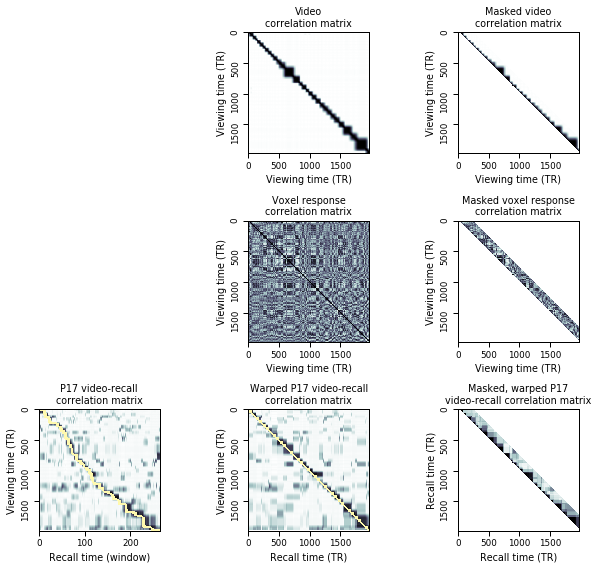

In [14]:
fig, (
    (v1, v2, v3), 
    (b1, b2, b3), 
    (r1, r2, r3)
) = plt.subplots(3, 3)

fig.set_size_inches(9, 8)
v1.axis('off')
b1.axis('off')

# video correlation matrix
v2 = sns.heatmap(vv_corrmat, 
                 xticklabels=500, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=0, 
                 vmax=1, 
                 cbar=False, 
                 ax=v2)
v2.set_xlabel('Viewing time (TR)')
v2.set_ylabel('Viewing time (TR)')
v2.set_title('Video\ncorrelation matrix')
for spine in v2.spines.values():
    spine.set_visible(True)

v2.collections[0].remove()
v2.imshow(vv_corrmat, aspect='equal', cmap=corrmat_cmap)

# masked video correlation matrix
v3 = sns.heatmap(vv_masked, 
                 xticklabels=500, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=0, 
                 vmax=1, 
                 cbar=False, 
                 ax=v3)
v3.set_xlabel('Viewing time (TR)')
v3.set_ylabel('Viewing time (TR)')
v3.set_title('Masked video\ncorrelation matrix')
for spine in v3.spines.values():
    spine.set_visible(True)

v3.collections[0].remove()
v3.imshow(vv_masked, aspect='equal', cmap=corrmat_cmap)

# voxel response correlation matrix
b2 = sns.heatmap(bb_corrmat, 
                 xticklabels=500, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=-1, 
                 vmax=1, 
                 cbar=False, 
                 ax=b2)
b2.set_xlabel('Viewing time (TR)')
b2.set_ylabel('Viewing time (TR)')
b2.set_title('Voxel response\ncorrelation matrix')
for spine in b2.spines.values():
    spine.set_visible(True)

b2.collections[0].remove()
b2.imshow(bb_corrmat, aspect='equal', cmap=corrmat_cmap)

# masked voxel response correlation matrix
b3 = sns.heatmap(bb_masked, 
                 xticklabels=500, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=-1, 
                 vmax=1, 
                 cbar=False, 
                 ax=b3)
b3.set_xlabel('Viewing time (TR)')
b3.set_ylabel('Viewing time (TR)')
b3.set_title('Masked voxel response\ncorrelation matrix')
for spine in b3.spines.values():
    spine.set_visible(True)

b3.collections[0].remove()
b3.imshow(bb_masked, aspect='equal', cmap=corrmat_cmap)


# P17 video-recall correlation matrix
r1 = sns.heatmap(vr_corrmat, 
                 xticklabels=100, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=0, 
                 vmax=1, 
                 cbar=False, 
                 ax=r1)
r1.set_xlabel('Recall time (window)')
r1.set_ylabel('Viewing time (TR)')
r1.set_title('P17 video-recall\ncorrelation matrix')
for spine in r1.spines.values():
    spine.set_visible(True)

r1.collections[0].remove()
r1.imshow(vr_corrmat, 
          aspect=(vr_corrmat.shape[1] / vr_corrmat.shape[0]), 
          cmap=corrmat_cmap)

for vid_ix, rec_ix in zip(vid_path, rec_path):
    pt = Rectangle((rec_ix, vid_ix), 
                   1, 1, 
                   linewidth=2, 
                   edgecolor=EDGECOLOR, 
                   facecolor=EDGECOLOR, 
                   zorder=2)
    r1.add_patch(pt)
    
# P17 warped video-recall correlation matrix
r2 = sns.heatmap(vr_dtw_corrmat, 
                 xticklabels=500, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=0, 
                 vmax=1, 
                 cbar=False, 
                 ax=r2)
r2.set_xlabel('Recall time (TR)')
r2.set_ylabel('Viewing time (TR)')
r2.set_title('Warped P17 video-recall\ncorrelation matrix')
for spine in r2.spines.values():
    spine.set_visible(True)

r2.collections[0].remove()
r2.imshow(vr_dtw_corrmat, aspect='equal', cmap=corrmat_cmap)
for i in range(1976):
    pt = Rectangle((i, i), 
                   1, 1, 
                   linewidth=2, 
                   edgecolor=EDGECOLOR, 
                   facecolor=EDGECOLOR, 
                   zorder=2)
    r2.add_patch(pt)
    
# P17 masked warped recall-recall correlation matrix
r3 = sns.heatmap(rr_masked, 
                 xticklabels=500, 
                 yticklabels=500, 
                 cmap=corrmat_cmap, 
                 vmin=0, 
                 vmax=1, 
                 cbar=False, 
                 ax=r3)
r3.set_xlabel('Recall time (TR)')
r3.set_ylabel('Recall time (TR)')
r3.set_title('Masked, warped P17\nvideo-recall correlation matrix')
for spine in r3.spines.values():
    spine.set_visible(True)

r3.collections[0].remove()
r3.imshow(rr_masked, aspect='equal', cmap=corrmat_cmap)

plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('tmp', 'brain_corrmats.pdf'), dpi=1000)
plt.show()

## Plot searchlight maps

In [15]:
combined_surface_left = np.zeros_like(vid_surface_left)
combined_surface_right = np.zeros_like(vid_surface_right)

combined_surface_left[vid_surface_left != 0] = 1
combined_surface_right[vid_surface_right != 0] = 1
combined_surface_left[rec_surface_left != 0] = 2
combined_surface_right[rec_surface_right != 0] = 2
combined_surface_left[(vid_surface_left != 0) & (rec_surface_left != 0)] = 3
combined_surface_right[(vid_surface_right != 0) & (rec_surface_right != 0)] = 3

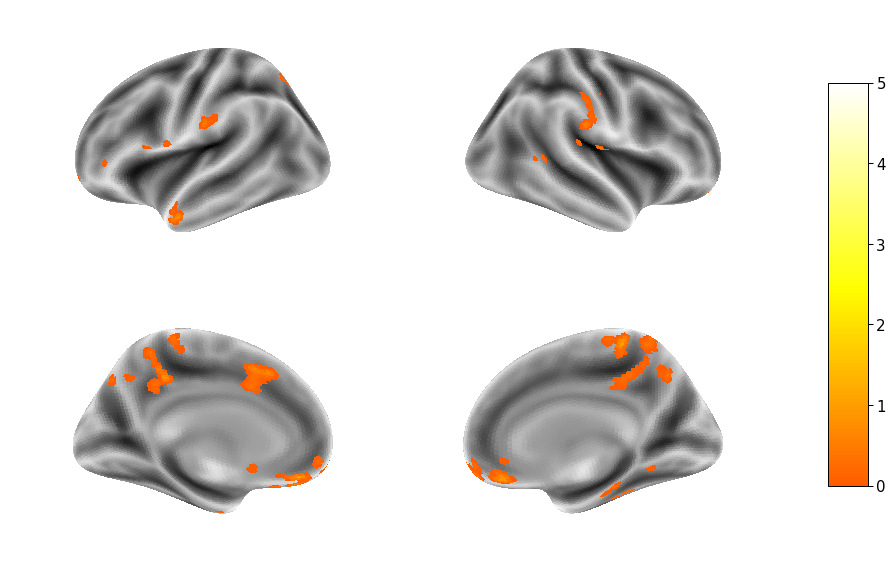

In [16]:
fig, (
    (a, b), 
    (c, d)
) = plt.subplots(2, 2, figsize=(11, 8), subplot_kw={'projection': '3d'})

plot_surf_stat_map(fsaverage.infl_left, 
                   vid_surface_left, 
                   hemi='left', 
                   view='lateral', 
                   bg_map=fsaverage.sulc_left, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=a)

plot_surf_stat_map(fsaverage.infl_right, 
                   vid_surface_right, 
                   hemi='right', 
                   view='lateral', 
                   bg_map=fsaverage.sulc_right, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=b)

plot_surf_stat_map(fsaverage.infl_left, 
                   vid_surface_left, 
                   hemi='left', 
                   view='medial', 
                   bg_map=fsaverage.sulc_left, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=c)

plot_surf_stat_map(fsaverage.infl_right, 
                   vid_surface_right, 
                   hemi='right', 
                   view='medial', 
                   bg_map=fsaverage.sulc_right, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=d)

plt.subplots_adjust()
plt.tight_layout()
cbar_ax = fig.add_axes([1.05, .15, .05, .7])
draw_colorbar(cbar_ax, 
              cmap=brain_cmap, 
              vmin=0, 
              vmax=5, 
              tick_freq=1., 
              ticklocation='right', 
              ticklabel_size=15)
# plt.savefig(FIG_DIR.joinpath('tmp', 'searchlight_video.pdf'), bbox_inches='tight')
plt.show()

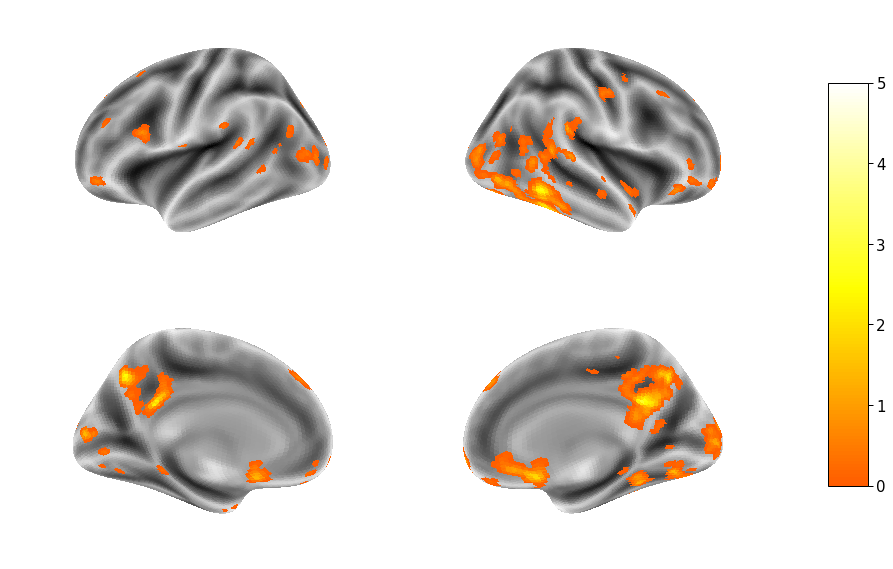

In [17]:
fig, (
    (a, b), 
    (c, d)
) = plt.subplots(2, 2, figsize=(11, 8), subplot_kw={'projection': '3d'})

plot_surf_stat_map(fsaverage.infl_left, 
                   rec_surface_left, 
                   hemi='left', 
                   view='lateral', 
                   bg_map=fsaverage.sulc_left, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=a)

plot_surf_stat_map(fsaverage.infl_right, 
                   rec_surface_right, 
                   hemi='right', 
                   view='lateral', 
                   bg_map=fsaverage.sulc_right, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=b)

plot_surf_stat_map(fsaverage.infl_left, 
                   rec_surface_left, 
                   hemi='left', 
                   view='medial', 
                   bg_map=fsaverage.sulc_left, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=c)

plot_surf_stat_map(fsaverage.infl_right, 
                   rec_surface_right, 
                   hemi='right', 
                   view='medial', 
                   bg_map=fsaverage.sulc_right, 
                   cmap=brain_cmap, 
                   threshold=.01, 
                   vmax=5, 
                   colorbar=False, 
                   axes=d)

plt.subplots_adjust()
plt.tight_layout()
cbar_ax = fig.add_axes([1.05, .15, .05, .7])
draw_colorbar(cbar_ax, 
              cmap=brain_cmap, 
              vmin=0, 
              vmax=5, 
              tick_freq=1., 
              ticklocation='right', 
              ticklabel_size=15)
# plt.savefig(FIG_DIR.joinpath('tmp', 'searchlight_recall.pdf'), bbox_inches='tight')
plt.show()